In [156]:
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

import astra

from tqdm import tqdm

%matplotlib inline

# PART A

#### 1. Calculate the Radon transform of an image and test the back-projection method.

##### Load $f_{\text{true}}$

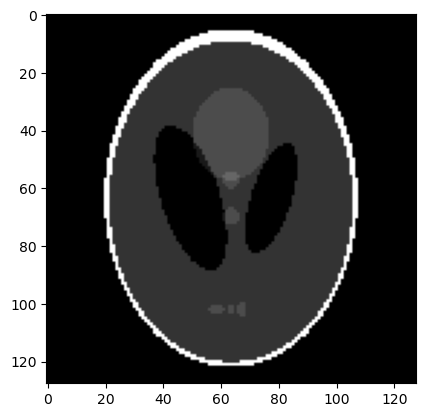

In [157]:
# Load data
SLphantom = np.load('data/SLphan.npy')

f_true = SLphantom
plt.imshow(f_true, cmap='gray')

##### Generate the Radon transform $g=Rf$

In [158]:
def Randon_Transform(f, det_count=128, angle_count=180, max_angle=np.pi):
    # Create volume geometries
    v, h = f.shape
    vol_geom = astra.create_vol_geom(v, h)

    # Create projector geometries

    detector_spacing = 1.
    # det_count = int(v / detector_spacing)
    angles = np.linspace(0, max_angle, angle_count, endpoint=False)
    proj_geom = astra.create_proj_geom('parallel', detector_spacing, det_count, angles)

    # Create projector
    projector_id = astra.create_projector('strip', proj_geom, vol_geom)

    # Radon transform (generate sinogram)
    sinogram_id, sinogram = astra.create_sino(f, projector_id)

    return vol_geom, proj_geom, projector_id, sinogram_id, sinogram

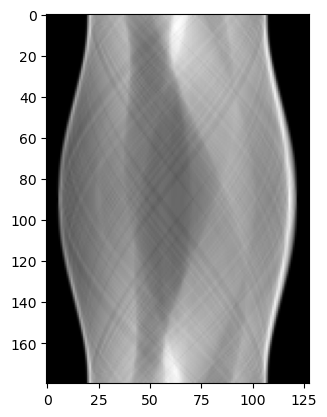

In [159]:
vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(f_true)
plt.imshow(g, cmap='gray')

##### Compute $unfiltered$ back-projection

In [160]:
def Radon_Back_Proj(vol_geom, sinogram_id, projector_id, ptype='BP'):
    # Create a data object for the reconstruction
    rec_id = astra.data2d.create('-vol', vol_geom)

    # Set up the parameters for a reconstruction via back-projection
    cfg = astra.astra_dict(ptype)
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ProjectorId'] = projector_id

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    # Run back-projection and get the reconstruction
    astra.algorithm.run(alg_id)
    f_rec = astra.data2d.get(rec_id)

    return f_rec

l2 distance:  376814.3861678726


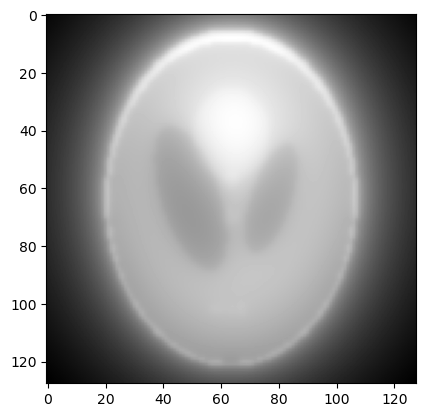

In [161]:
f_rec = Radon_Back_Proj(vol_geom, g_id, proj_id)
print('l2 distance: ', np.linalg.norm(f_rec - f_true))
plt.imshow(f_rec, cmap='gray')

##### Compute $filtered$ back-projection

l2 distance:  7.360654329544242


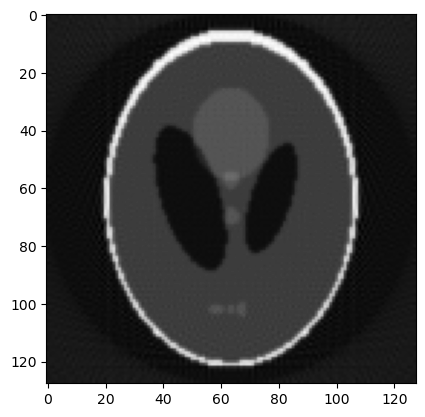

In [162]:
f_filtered_rec = Radon_Back_Proj(vol_geom, g_id, proj_id, ptype='FBP')
print('l2 distance: ', np.linalg.norm(f_filtered_rec - f_true))
plt.imshow(f_filtered_rec, cmap='gray')

##### Add noise to the data $g$

In [93]:
def add_noise_to_sino(proj_geom, sinogram, theta=1.0):
    sinogram_noisy = astra.functions.add_noise_to_sino(sinogram, theta)
    sinogram_noisy_id = astra.data2d.create('-sino', proj_geom, sinogram_noisy)
    return sinogram_noisy_id, sinogram_noisy

In [106]:
# noises = np.linspace(20, 10000, num=100)
noises = np.logspace(1, 2.86, base=25, num=100)
g_l2ds = []
g_vars = []
rec_l2ds = []
vol_geom, proj_geom, proj_id, sinogram_id, sinogram = Randon_Transform(f_true)
for noise in tqdm(noises):
    g_nosiy_id, g_noisy = add_noise_to_sino(proj_geom, sinogram, theta=noise)
    g_l2ds.append(np.linalg.norm(g_noisy - sinogram))
    g_vars.append(np.var(g_noisy - sinogram))
    f_noisy_rec = Radon_Back_Proj(vol_geom, g_nosiy_id, proj_id, ptype='FBP')
    rec_l2ds.append(np.linalg.norm(f_noisy_rec - f_true))

100%|██████████| 100/100 [00:05<00:00, 18.95it/s]


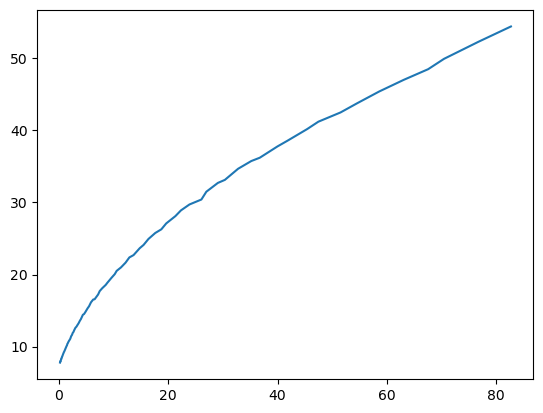

In [108]:
plt.plot(g_vars, rec_l2ds)

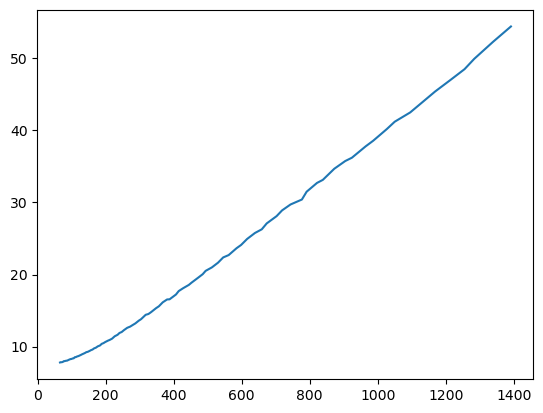

In [109]:
plt.plot(g_l2ds, rec_l2ds)

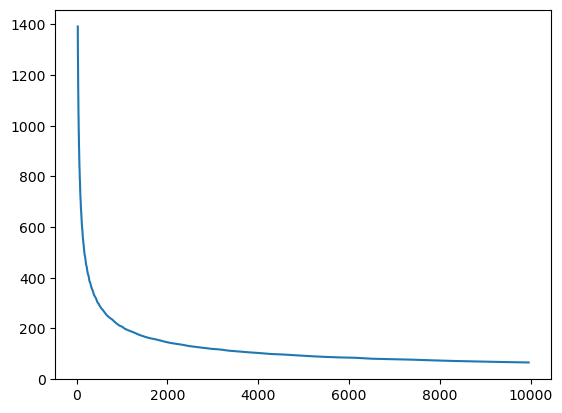

In [110]:
plt.plot(noises, g_l2ds)

#### 2. Calculate an explicit matrix form of the Radon transform and investigate its SVD.

##### Construct explicit matrix of Radon Transform

In [147]:
a = np.array([
    [0, 1, 2],
    [2, 3, 4],
    [4, 5, 6]
])
print(a.reshape((9, 1)))
h, w = 3, 4
for i in tqdm(range(h * w)):
    r = i // w
    c = i % w
    print(r, c)

[[0]
 [1]
 [2]
 [2]
 [3]
 [4]
 [4]
 [5]
 [6]]


100%|██████████| 12/12 [00:00<00:00, 71799.78it/s]

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3


In [175]:
def construct_Radon_Matrix(h, w, n_angles, max_angle, n_projs):
    
    f = np.zeros((h, w))
    n_pixels = h * w
    R = np.zeros((n_angles * n_projs, n_pixels))
    for i in tqdm(range(n_pixels)):
        r = i // w
        c = i % w
        f[r, c] = 1
        vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(f, det_count=n_projs, angle_count=n_angles, max_angle=max_angle)
        R[:, i] = g.reshape((n_angles * n_projs,))
        f[r, c] = 0
    
    return R

def apply_Radon_Matrix(R, im, n_angles, n_projs):
    h, w = im.shape
    return (R @ im.reshape((h * w))).reshape((n_angles, n_projs))

In [149]:
R = construct_Radon_Matrix(128, 128, 10, np.pi, 128)

100%|██████████| 16384/16384 [00:34<00:00, 471.72it/s]


In [165]:
R45 = construct_Radon_Matrix(128, 128, 10, np.pi / 4, 128)

100%|██████████| 16384/16384 [00:35<00:00, 465.96it/s]


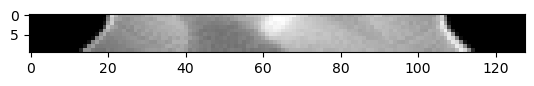

In [170]:
vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(f_true, det_count=128, angle_count=10, max_angle=np.pi/4)
plt.imshow(g, cmap='gray')

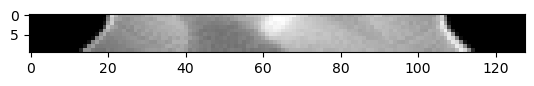

In [176]:
plt.imshow(apply_Radon_Matrix(R45, f_true, 10, 128), cmap='gray')

##### SVD analysis

$\text{i)}$ $64\times 64$ image, $45$ projection samples, $\text{angles}=[0:4:179]$

In [177]:
R1 = construct_Radon_Matrix(64, 64, 45, np.pi, 45)

100%|██████████| 4096/4096 [00:08<00:00, 469.20it/s]


In [181]:
U1, s1, Vh1 = scipy.linalg.svd(R1)

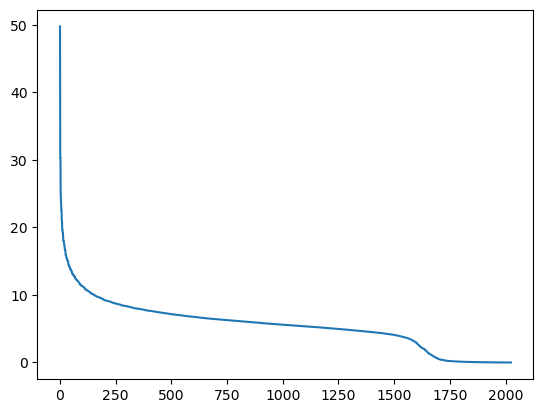

In [182]:
plt.plot(s1)

$\text{ii)}$ $64\times 64$ image, $45$ projection samples, $\text{angles}=[0:1:44]$

In [180]:
R2 = construct_Radon_Matrix(64, 64, 45, np.pi/4, 45)

100%|██████████| 4096/4096 [00:08<00:00, 469.70it/s]


In [183]:
U2, s2, Vh2 = scipy.linalg.svd(R2)

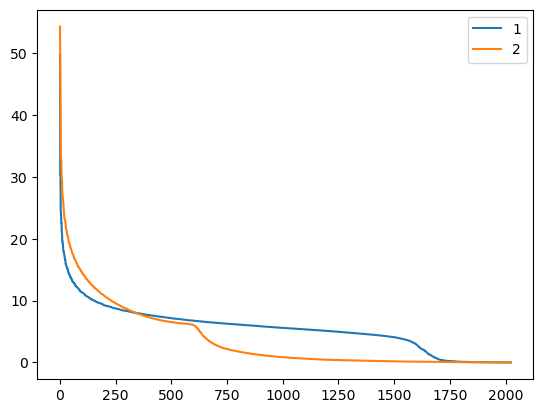

In [187]:
plt.plot(s1, label='1')
plt.plot(s2, label='2')
plt.legend()

#### 3. Implement a matrix-free regularised least-squares solver for the Radon Transform.

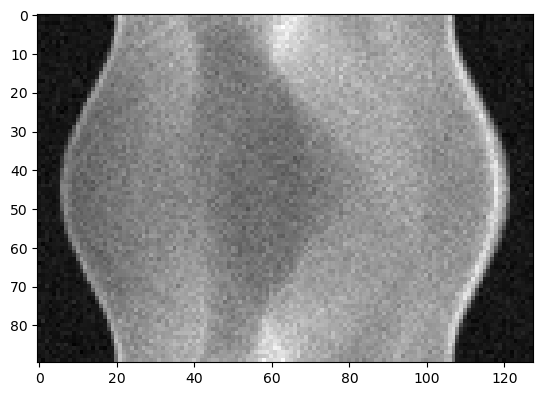

In [338]:
vol_geom, proj_geom, proj_id, g_id, grt = Randon_Transform(f_true, 128, 90)
g_nosiy_id, g_noisy = add_noise_to_sino(proj_geom, grt, theta=1000)
plt.imshow(g_noisy, cmap='gray')

l2 distance:  13.72203534727414


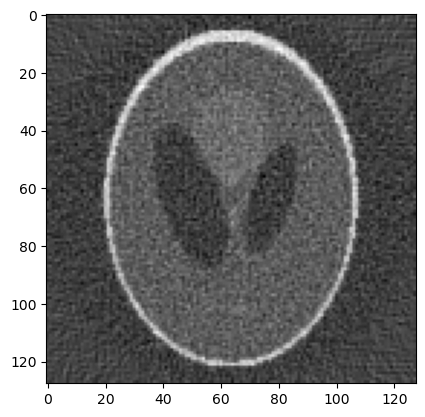

In [339]:
f_rec = Radon_Back_Proj(vol_geom, g_nosiy_id, proj_id, 'FBP')
print('l2 distance: ', np.linalg.norm(f_rec - f_true))
plt.imshow(f_rec, cmap='gray')

In [293]:
def construct_Radon_Operator(h, w, n_projs, n_angles, max_angle):

    def forward(v):
        im = v.reshape((h, w))
        vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(im, n_projs, n_angles, max_angle)
        return g.reshape((n_projs * n_angles,))

    def backward(v):
        g = v.reshape((n_angles, n_projs))
        vol_geom = astra.create_vol_geom(h, w)
        angles = np.linspace(0, max_angle, n_angles, endpoint=False)
        proj_geom = astra.create_proj_geom('parallel', 1., n_projs, angles)
        projector_id = astra.create_projector('strip', proj_geom, vol_geom)
        _, back_projection = astra.create_backprojection(g, projector_id, returnData=True)
        return back_projection.reshape((h * w,))

    return scipy.sparse.linalg.LinearOperator((n_projs * n_angles, h * w), matvec=forward, rmatvec=backward)

In [340]:
R_op = construct_Radon_Operator(128, 128, 128, 90, np.pi)
# g_op = apply_Radon_Matrix(R_op, f_true, 90, 128)

In [244]:
def apply_Radon_Back_Projection_Matrix(Rt, g, h, w):
    n_angles, n_projs = g.shape
    return (Rt @ g.reshape((n_angles * n_projs))).reshape((h, w))

In [294]:
def solve_with_l2_reg(alpha, A, g):
    def M_f(v):
        Af = A @ v
        If = np.sqrt(alpha) * v
        z = np.hstack((Af, If))
        return z
    def MT_b(v):
        h, w = A.shape
        Atf = A.T @ v[:h]
        Itf = np.sqrt(alpha) * v[h:]
        z = Atf + Itf
        return z
    h, w = A.shape
    M = scipy.sparse.linalg.LinearOperator((h + w, w), matvec=M_f, rmatvec=MT_b)
    b = np.hstack((g, np.zeros(w)))
    x_lsqr = scipy.sparse.linalg.lsqr(M, b)
    return x_lsqr

In [295]:
gh, gw = g_noisy.shape
x_lsqr = solve_with_l2_reg(10, R_op, g_noisy.reshape((gh * gw)))

Status: 2
Iteration number: 87

l2 distance:  14.690774018454425


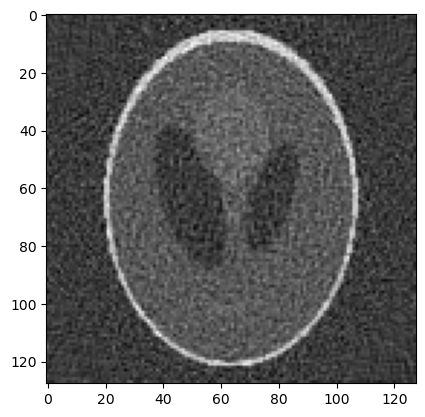

In [296]:
print('Status: %d\nIteration number: %d\n' % (x_lsqr[1], x_lsqr[2]))
f_rec_lsqr = x_lsqr[0].reshape((128, 128))
print('l2 distance: ', np.linalg.norm(f_rec_lsqr - f_true))
plt.imshow(f_rec_lsqr, cmap='gray')

0.029667698012457954 1.3425250048069832
73.494286


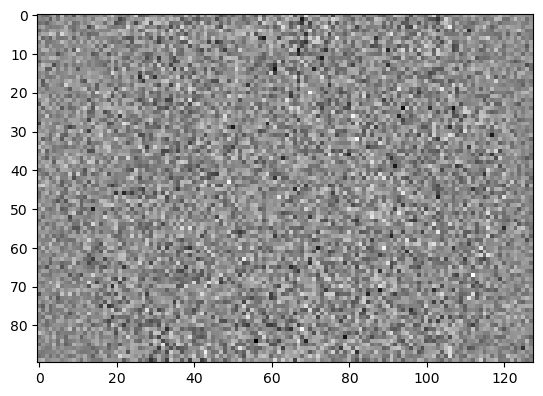

In [303]:
noise_matrix = g_noisy - grt
n = noise_matrix.shape[0] * noise_matrix.shape[1]
mu = np.sum(noise_matrix) / n
sig = np.sqrt(np.sum(np.power(noise_matrix - mu, 2)) / (n - 1))
print(mu, sig)
Af = apply_Radon_Matrix(R_op, f_rec_lsqr, 90, 128)
plt.imshow(grt - g_noisy, cmap='gray')
print(np.linalg.norm(Af - g_noisy))

In [306]:
def dp_alpha(alpha, sig, h, w, n_angles, n_projs):
    gh, gw = g_noisy.shape
    x_lsqr = solve_with_l2_reg(alpha, R_op, g_noisy.reshape((gh * gw)))
    f_rec_lsqr = x_lsqr[0].reshape((h, w))
    Af = apply_Radon_Matrix(R_op, f_rec_lsqr, n_angles, n_projs)
    r_alpha_norm = np.linalg.norm(Af - g_noisy)
    dp_alpha = r_alpha_norm * r_alpha_norm / (gh * gw) - sig * sig
    return dp_alpha
sol = scipy.optimize.root(dp_alpha, x0=1, args=(sig, f_true.shape[0], f_true.shape[1], 90, 128))

    fjac: array([[-1.]])
     fun: -3.077485701830085e-07
 message: 'The solution converged.'
    nfev: 18
     qtf: array([3.0774857e-07])
       r: array([7.27595761e-12])
  status: 1
 success: True
       x: array([98.93628997])
Status: 2
Iteration number: 33

l2 distance:  11.951104100647973


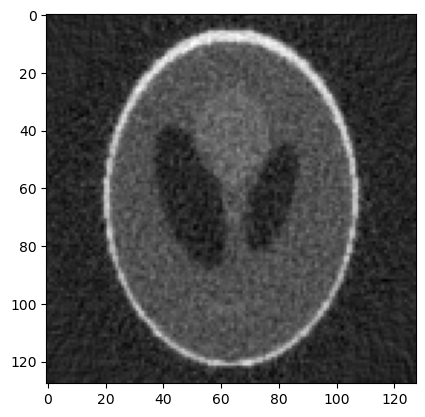

In [308]:
print(sol)
alpha = sol.x
gh, gw = g_noisy.shape
x_lsqr = solve_with_l2_reg(alpha, R_op, g_noisy.reshape((gh * gw)))
print('Status: %d\nIteration number: %d\n' % (x_lsqr[1], x_lsqr[2]))
f_rec_lsqr = x_lsqr[0].reshape((128, 128))
print('l2 distance: ', np.linalg.norm(f_rec_lsqr - f_true))
plt.imshow(f_rec_lsqr, cmap='gray')

In [309]:
noise_matrix = g_noisy - grt
n = noise_matrix.shape[0] * noise_matrix.shape[1]
mu = np.sum(noise_matrix) / n
sig = np.sqrt(np.sum(np.power(noise_matrix - mu, 2)) / (n - 1))
print(mu, sig)
Af = apply_Radon_Matrix(R_op, f_rec_lsqr, 90, 128)
r_alpha_norm = np.linalg.norm(Af - g_noisy)
dp_alpha = r_alpha_norm * r_alpha_norm / (gh * gw) - sig * sig
print(dp_alpha)

0.029667698012457954 1.3425250048069832
-3.077485701830085e-07


In [319]:
def construct_delta_xy(h, w):
    d = scipy.sparse.diags([1, -1], [0, 1], shape=(w, w))
    ri = np.eye(h)
    gx = scipy.sparse.kron(ri, d)
    gy = scipy.sparse.kron(d, ri)
    return gx, gy
def apply_gradient_to_image(g, im):
    h, w = im.shape
    imv = im.reshape((h * w,))
    gim = g @ imv
    return gim.reshape((h, w))

In [336]:
gx, gy = construct_delta_xy(128, 128)
gxa = gx.toarray()

In [337]:
def solve_with_l1_reg(alpha, A, g, h, w):
    gx, gy = construct_delta_xy(h, w)
    def M_f(v):
        Af = A @ v
        gfx = np.sqrt(alpha) * gx @ v
        gfy = np.sqrt(alpha) * gy @ v
        z = np.hstack((Af, gfx, gfy))
        return z
    def MT_b(v):
        h, w = A.shape
        Atf = A.T @ v[:h]
        gfxt = np.sqrt(alpha) * gx.T @ v[h:h+w]
        gfyt = np.sqrt(alpha) * gy.T @ v[h+w:h+w+w]
        z = Atf + gfxt + gfyt
        return z
    h, w = A.shape
    M = scipy.sparse.linalg.LinearOperator((h + w + w, w), matvec=M_f, rmatvec=MT_b)
    b = np.hstack((g, np.zeros(w), np.zeros(w)))
    x_lsqr = scipy.sparse.linalg.lsqr(M, b)
    return x_lsqr

In [341]:
gh, gw = g_noisy.shape
x_lsqr = solve_with_l1_reg(10, R_op, g_noisy.reshape((gh * gw)), f_true.shape[0], f_true.shape[1])

Status: 2
Iteration number: 107

l2 distance:  12.05928664140396


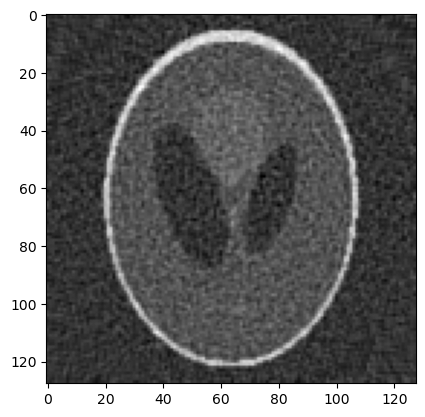

In [342]:
print('Status: %d\nIteration number: %d\n' % (x_lsqr[1], x_lsqr[2]))
f_rec_lsqr = x_lsqr[0].reshape((128, 128))
print('l2 distance: ', np.linalg.norm(f_rec_lsqr - f_true))
plt.imshow(f_rec_lsqr, cmap='gray')

In [352]:
def dp_alpha_l1(alpha, sig, h, w, n_angles, n_projs):
    gh, gw = g_noisy.shape
    x_lsqr = solve_with_l1_reg(alpha.item(), R_op, g_noisy.reshape((gh * gw)), h, w)
    f_rec_lsqr = x_lsqr[0].reshape((h, w))
    Af = apply_Radon_Matrix(R_op, f_rec_lsqr, n_angles, n_projs)
    r_alpha_norm = np.linalg.norm(Af - g_noisy)
    dp_alpha = r_alpha_norm * r_alpha_norm / (gh * gw) - sig * sig
    return dp_alpha
sol = scipy.optimize.root(dp_alpha_l1, x0=1, args=(sig, f_true.shape[0], f_true.shape[1], 90, 128))

    fjac: array([[-1.]])
     fun: 2.0087773178190105e-07
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 21
     qtf: array([-2.00877732e-07])
       r: array([0.])
  status: 5
 success: False
       x: array([97.79830589])
Status: 2
Iteration number: 48

l2 distance:  11.883506039700377


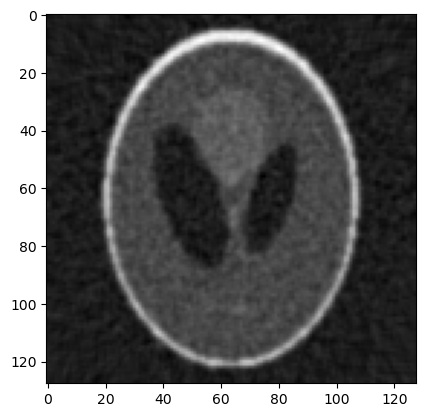

In [353]:
print(sol)
alpha = sol.x.item()
gh, gw = g_noisy.shape
x_lsqr = solve_with_l1_reg(alpha, R_op, g_noisy.reshape((gh * gw)), f_true.shape[0], f_true.shape[1])
print('Status: %d\nIteration number: %d\n' % (x_lsqr[1], x_lsqr[2]))
f_rec_lsqr = x_lsqr[0].reshape((128, 128))
print('l2 distance: ', np.linalg.norm(f_rec_lsqr - f_true))
plt.imshow(f_rec_lsqr, cmap='gray')

In [359]:
th = 100
tw = 50
tgx, tgy = construct_delta_xy(th, tw)
u = np.random.random((th * tw,))
v = np.random.random((th * tw,))
np.allclose(np.dot(tgy @ u, v), np.dot(u, tgy.T @ v))

True